# Retinal Vessel Segmentation
## Marcelina Gancewska (156024)
### All required imports

In [48]:
# All required imports

# Core Python Libraries
import os
import io

# Numerical operations
import numpy as np
import scipy as sp

# Image Processing 
import cv2
import skimage
from skimage.filters import frangi

# Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import ConfusionMatrixDisplay

# Machine Learning Metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import moments_hu
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Medical image processing
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, disk
# Image meta parameters
save = True
savePath = "./image_processing"
inputImage = './input/01.jpg'




Image preprocessing

In [ ]:
img = cv2.imread(inputImage) # read image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # to rgb

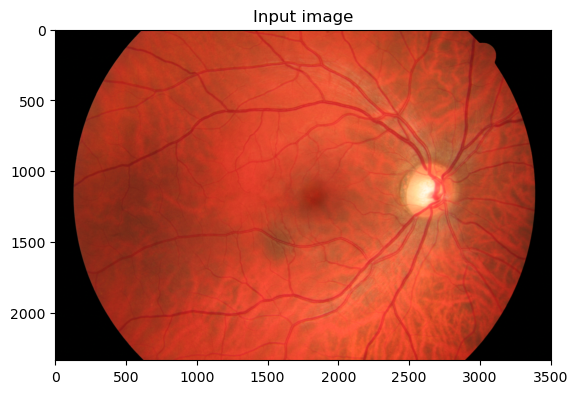

In [11]:
plt.title('Input image')
plt.imshow(img)
if save:
    plt.savefig(f'{savePath}/inputImage.png')

Visualize input image via color channels

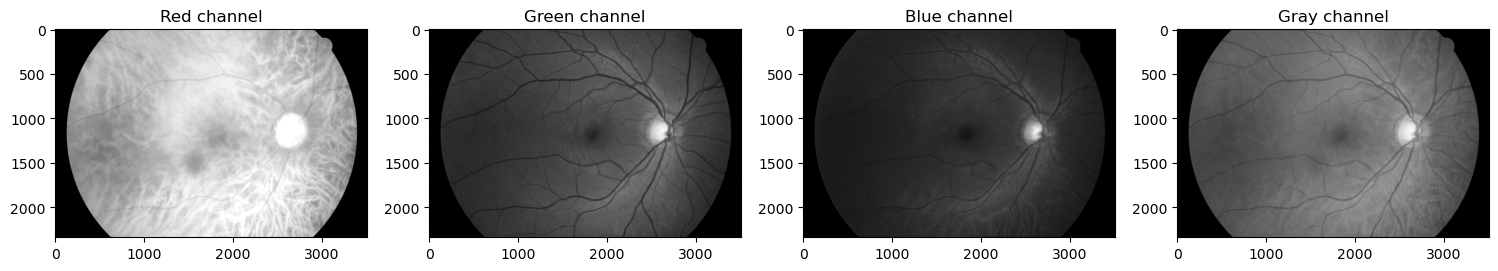

In [12]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

ax[0].set_title('Red channel')
ax[0].imshow(img[:, :, 0], cmap='gray')

ax[1].set_title('Green channel')
ax[1].imshow(img[:, :, 1], cmap='gray')

ax[2].set_title('Blue channel')
ax[2].imshow(img[:, :, 2], cmap='gray')

ax[3].set_title('Gray channel')
ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')

if save:
    plt.savefig(f'{savePath}/channels.png')

Additional image processing : frangi filter, color historgam normization and?

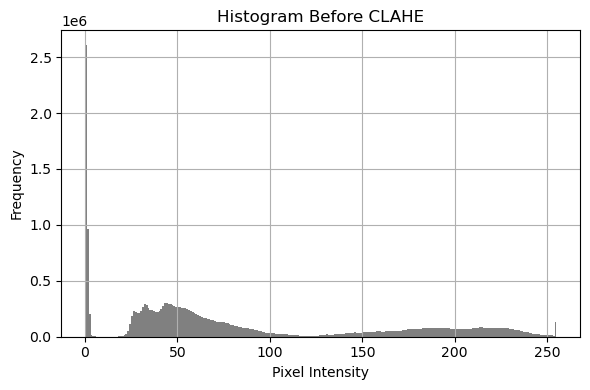

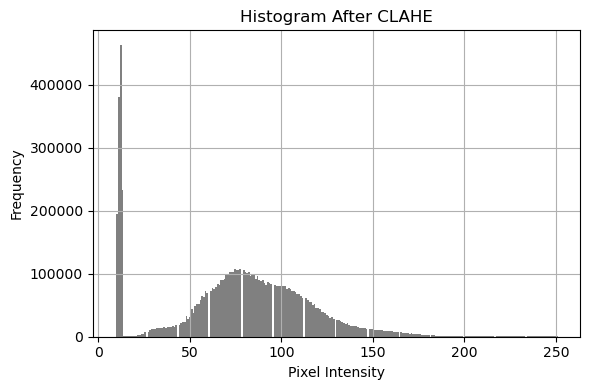

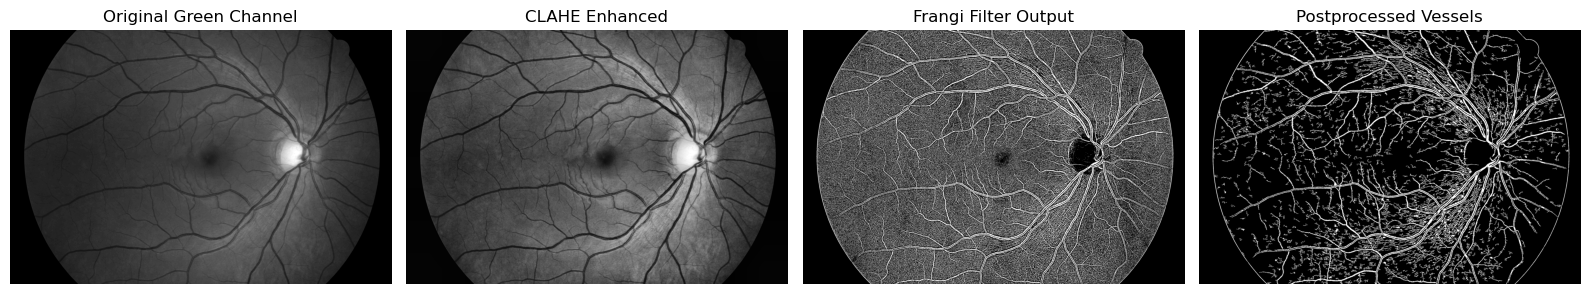

In [34]:
def preprocess_image(image):
    # Take green channel from the image
    green_channel = image[:, :, 1]
    # Removes overly dark (≤10) and overly bright (≥245) pixels to reduce noise and improve contrast
    clipped = np.clip(green_channel, 10, 245)
    clahe_processor = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
    enhanced = clahe_processor.apply(clipped)
    return clipped, enhanced

def plot_histogram(image, title):
    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=256, color='gray')
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def apply_frangi_filter(image, threshold=0.004, sigma_start=1, sigma_end=3, sigma_step=0.5):
    filtered = frangi(
        image,
        sigmas=np.arange(sigma_start, sigma_end, sigma_step),
        black_ridges=True,
        scale_range=None,
        scale_step=None,
        alpha=0.5,
        beta=0.5,
        gamma=15
    )
    normalized = (filtered - np.min(filtered)) / (np.max(filtered) - np.min(filtered))
    binary_output = (normalized > threshold).astype(np.uint8) * 255
    return binary_output

def plot_results(original, enhanced, filtered, processed, output_path=None):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    
    titles = ['Original Green Channel', 'CLAHE Enhanced', 
              'Frangi Filter Output', 'Postprocessed Vessels']
    images = [original, enhanced, filtered, processed]
    
    for ax, img, title in zip(axs, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    
    if output_path:
        fig.savefig(f'{output_path}/vessel_detection_pipeline.png')

def postprocess_vessels(binary_image, min_size=150, closing_radius=2):
    cleaned = remove_small_objects(binary_image.astype(bool), min_size=min_size)
    filled = remove_small_holes(cleaned, area_threshold=min_size)
    return (filled.astype(np.uint8)) * 255

# --- Main execution ---

result_list = []

gray_img, clahe_img = preprocess_image(img)

# Plot histograms before and after CLAHE
plot_histogram(img, 'Histogram Before CLAHE')
plot_histogram(clahe_img, 'Histogram After CLAHE')

frangi_mask = apply_frangi_filter(clahe_img)
post_processed_mask = postprocess_vessels(frangi_mask)

plot_results(gray_img, clahe_img, frangi_mask, post_processed_mask,
             output_path=savePath if save else None)

result_list.append(frangi_mask)



Performance Metrics:

Confusion Matrix:
True Positives: 523595
False Positives: 554960
True Negatives: 6796496
False Negatives: 310293
Accuracy: 0.8943
Sensitivity (Recall): 0.6279
Specificity: 0.9245
Arithmetic Mean (Sensitivity+Specificity)/2: 0.7762
Geometric Mean sqrt(Sensitivity*Specificity): 0.7619


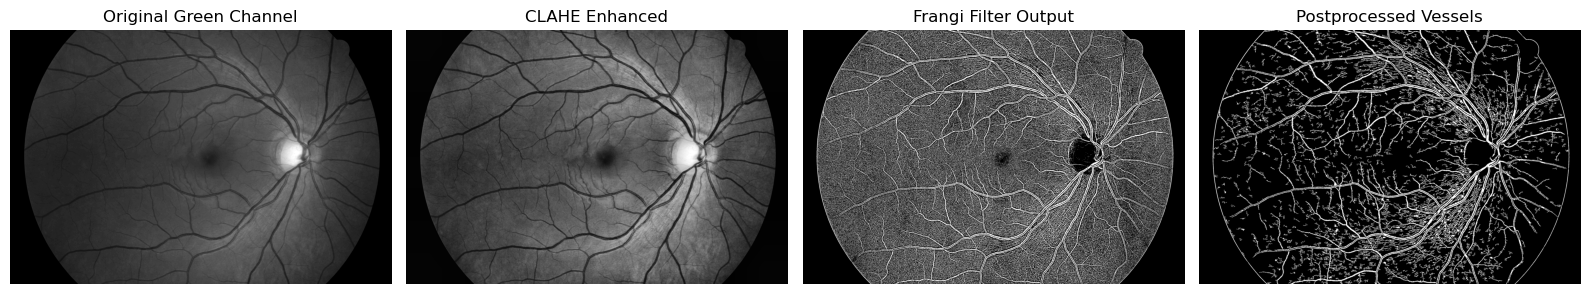

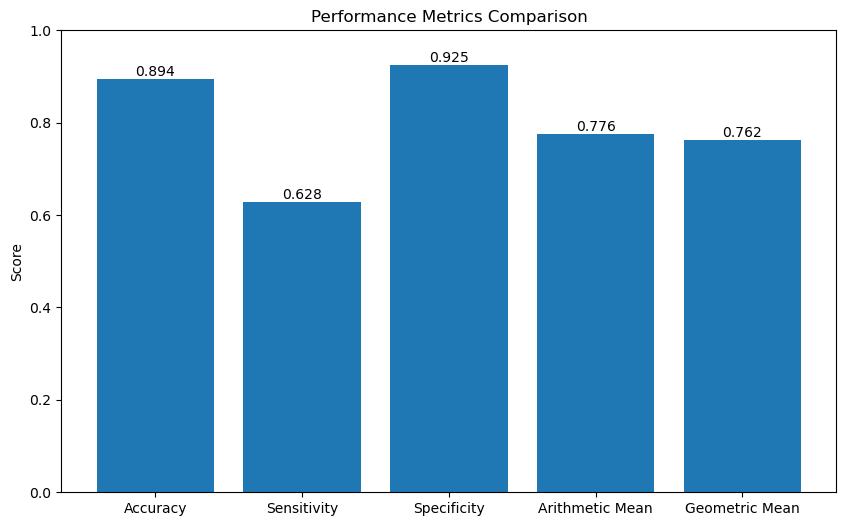

In [35]:
def evaluate_performance(predicted_mask, ground_truth_mask):
    """
    Calculate performance metrics for vessel segmentation.
    """
    # Convert masks to boolean (0=False=background, 1=True=vessel)
    pred = predicted_mask == 255
    gt = ground_truth_mask == 255
    
    # Calculate confusion matrix components
    tp = np.sum(pred & gt)  # True positives
    fp = np.sum(pred & ~gt)  # False positives
    tn = np.sum(~pred & ~gt)  # True negatives
    fn = np.sum(~pred & gt)  # False negatives
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    sensitivity = tp / (tp + fn)  # Recall or true positive rate
    specificity = tn / (tn + fp)  # True negative rate
    
    # Balanced metrics
    arithmetic_mean = (sensitivity + specificity) / 2
    geometric_mean = np.sqrt(sensitivity * specificity)
    
    # Create confusion matrix in dictionary form
    confusion_matrix = {
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    }
    
    metrics = {
        'Confusion Matrix': confusion_matrix,
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'Arithmetic Mean (Sensitivity+Specificity)/2': arithmetic_mean,
        'Geometric Mean sqrt(Sensitivity*Specificity)': geometric_mean
    }
    
    return metrics

def plot_metrics_comparison(metrics_dict, output_path=None):
    """Plot the metrics for visual comparison."""
    metrics_to_plot = {
        'Accuracy': metrics_dict['Accuracy'],
        'Sensitivity': metrics_dict['Sensitivity (Recall)'],
        'Specificity': metrics_dict['Specificity'],
        'Arithmetic Mean': metrics_dict['Arithmetic Mean (Sensitivity+Specificity)/2'],
        'Geometric Mean': metrics_dict['Geometric Mean sqrt(Sensitivity*Specificity)']
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_to_plot.keys(), metrics_to_plot.values())
    ax.set_ylim(0, 1)
    ax.set_title('Performance Metrics Comparison')
    ax.set_ylabel('Score')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    if output_path:
        fig.savefig(f'{output_path}/performance_metrics.png')


result_list = []

# gray_img, clahe_img = preprocess_image(img)
# frangi_mask = apply_frangi_filter(clahe_img)
# post_processed_mask = postprocess_vessels(frangi_mask)

# Evaluate performance (you need to provide ground_truth_mask)
ground_truth_mask = cv2.imread('./groundTruth/01.png', cv2.IMREAD_GRAYSCALE)
#metrics = evaluate_performance(frangi_mask, ground_truth_mask)
metrics = evaluate_performance(post_processed_mask, ground_truth_mask)

# Print metrics
print("\nPerformance Metrics:")
for key, value in metrics.items():
    if key == 'Confusion Matrix':
        print("\nConfusion Matrix:")
        for k, v in value.items():
            print(f"{k}: {v}")
    else:
        print(f"{key}: {value:.4f}")

# Plot results including metrics
plot_results(gray_img, clahe_img, frangi_mask, post_processed_mask, output_path=savePath if save else None)
plot_metrics_comparison(metrics, output_path=savePath if save else None)

result_list.append(frangi_mask)


Results for 01.jpg:
{'Confusion Matrix': {'True Positives': 534639, 'False Positives': 1942588, 'True Negatives': 5408868, 'False Negatives': 299249}, 'Accuracy': 0.7261157258632014, 'Sensitivity (Recall)': 0.6411400571779423, 'Specificity': 0.7357546586689766, 'Arithmetic Mean (Sensitivity+Specificity)/2': 0.6884473579234595, 'Geometric Mean sqrt(Sensitivity*Specificity)': 0.68682005207184}

Results for 02.jpg:
{'Confusion Matrix': {'True Positives': 520068, 'False Positives': 1719268, 'True Negatives': 5657638, 'False Negatives': 288370}, 'Accuracy': 0.7547277182241822, 'Sensitivity (Recall)': 0.6432997954079348, 'Specificity': 0.7669391476589237, 'Arithmetic Mean (Sensitivity+Specificity)/2': 0.7051194715334292, 'Geometric Mean sqrt(Sensitivity*Specificity)': 0.7024042972386498}

Results for 03.jpg:
{'Confusion Matrix': {'True Positives': 521464, 'False Positives': 2045200, 'True Negatives': 5275973, 'False Negatives': 342707}, 'Accuracy': 0.7082704160020642, 'Sensitivity (Recall)'

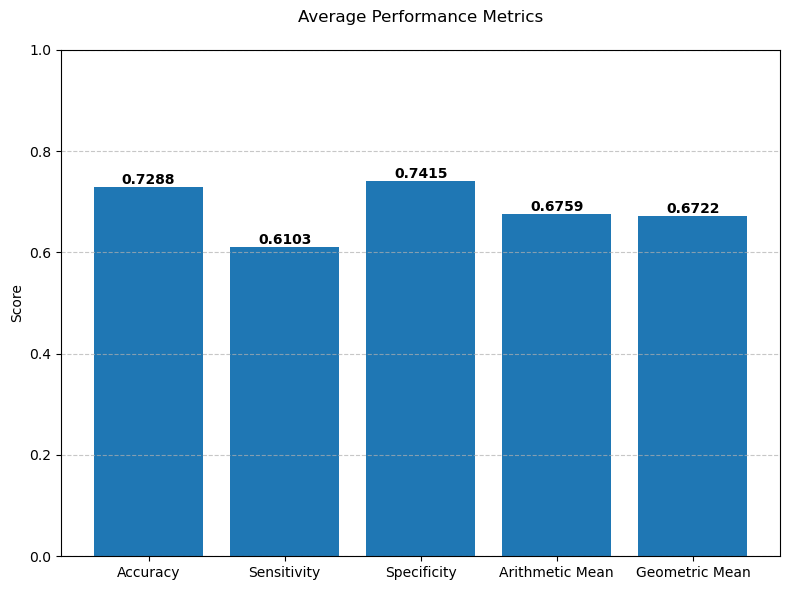

In [40]:
input_files = ['01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg']
ground_truth_files = ['01.png', '02.png', '03.png', '04.png', '05.png']
results = []

for i in range(len(input_files)):
    # Load and process image
    img = cv2.imread(f'./input/{input_files[i]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img, clahe_img = preprocess_image(img)
    frangi_mask = apply_frangi_filter(clahe_img)
    ground_truth_mask = cv2.imread(f'./groundTruth/{ground_truth_files[i]}', cv2.IMREAD_GRAYSCALE)
    
    # Evaluate performance
    metrics = evaluate_performance(frangi_mask, ground_truth_mask)
    results.append(metrics)
    
    # Print individual results
    print(f"\nResults for {input_files[i]}:")
    print(metrics)

# Calculate average metrics
if results:
    avg_metrics = {
        'Accuracy': np.nanmean([m['Accuracy'] for m in results]),
        'Sensitivity': np.nanmean([m['Sensitivity (Recall)'] for m in results]),
        'Specificity': np.nanmean([m['Specificity'] for m in results]),
        'Arithmetic_Mean': np.nanmean([m['Arithmetic Mean (Sensitivity+Specificity)/2'] for m in results]),
        'Geometric_Mean': np.nanmean([m['Geometric Mean sqrt(Sensitivity*Specificity)'] for m in results])
    }

    # Print average results
    print("\n=== AVERAGE RESULTS ACROSS ALL IMAGES ===")
    print(f"Accuracy: {avg_metrics['Accuracy']:.4f}")
    print(f"Sensitivity: {avg_metrics['Sensitivity']:.4f}")
    print(f"Specificity: {avg_metrics['Specificity']:.4f}")
    print(f"Arithmetic Mean: {avg_metrics['Arithmetic_Mean']:.4f}")
    print(f"Geometric Mean: {avg_metrics['Geometric_Mean']:.4f}")


# After calculating avg_metrics 

def plot_average_results(avg_metrics):
    # Create single subplot for metrics
    fig, ax1 = plt.subplots(figsize=(8, 6))
    
    # Plot metrics
    metrics_to_plot = {
        'Accuracy': avg_metrics['Accuracy'],
        'Sensitivity': avg_metrics['Sensitivity'],
        'Specificity': avg_metrics['Specificity'],
        'Arithmetic Mean': avg_metrics['Arithmetic_Mean'],
        'Geometric Mean': avg_metrics['Geometric_Mean']
    }
    
    bars = ax1.bar(metrics_to_plot.keys(), metrics_to_plot.values())
    ax1.set_ylim(0, 1)
    ax1.set_title('Average Performance Metrics', pad=20)
    ax1.set_ylabel('Score')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Call the plotting function after calculating averages
plot_average_results(avg_metrics)


In [50]:
from skimage.measure import moments, moments_hu
def extract_features(image_patch):
    features = []

    # 1. Variance of colors
    variance = np.var(image_patch)
    features.append(variance)

    # 2. Hu moments only (skip central moments)
    m = moments(image_patch)
    hu = moments_hu(m)
    features.extend(hu)

    return np.array(features)

    

def create_dataset(image, mask, patch_size=9):
    half = patch_size // 2
    h, w = image.shape
    X = []
    y = []

    for y_pos in range(half, h - half):
        for x_pos in range(half, w - half):
            patch = image[y_pos - half:y_pos + half + 1, x_pos - half:x_pos + half + 1]
            label = mask[y_pos, x_pos]
            features = extract_features(patch)
            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)



# Tworzenie zbiorów cech i etykiet z obrazu i maski
img = cv2.imread('./input/01.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img, clahe_img = preprocess_image(img)
ground_truth_mask = cv2.imread('./groundTruth/01.png', cv2.IMREAD_GRAYSCALE)
gt = ground_truth_mask == 255

img2 = cv2.imread('./input/02.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gray_img2, clahe_img2 = preprocess_image(img2)
ground_truth_mask2 = cv2.imread('./groundTruth/02.png', cv2.IMREAD_GRAYSCALE)
gt2 = ground_truth_mask2 == 255

print('Creating dataset...')
X_train_full, y_train_full = create_dataset(clahe_img, gt)
X_test, y_test = create_dataset(clahe_img2, gt2)
print(f"Zbiór treningowy: {X_train_full.shape}, {y_train_full.shape}")


Creating dataset...
Zbiór treningowy: (8138688, 8), (8138688,)


Wymagania na 4

In [51]:
import numpy as np
import cv2
from skimage.measure import moments, moments_hu
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# === 2. Undersampling – zrównoważ dane treningowe ===
vessel_idx = np.where(y_train_full == 1)[0]
background_idx = np.where(y_train_full == 0)[0]

# Undersampling klasy tła
background_sampled = resample(
    background_idx, 
    replace=False, 
    n_samples=len(vessel_idx), 
    random_state=42
)
print('laczenie próbek...')
# Połącz próbki
selected_idx = np.concatenate((vessel_idx, background_sampled))
X_train = X_train_full[selected_idx]
y_train = y_train_full[selected_idx]

# === 3. Trening klasyfikatora ===
print('fitting classifier...')
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# === 4. Ewaluacja ===
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność klasyfikatora: {accuracy:.2f}")


laczenie próbek...
fitting classifier...
Dokładność klasyfikatora: 0.91
